Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [1]:
HYPERTRAINING = False
CV = 5
SCORING = ''
SAVE_MODEL_NAME = 'offense_regressor'
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offense_potential_predictor_regression_metrics_80"
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','shooting_technique','mental'
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', 
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']

PLAYER_ATTRIBUTES = [ 'shooting','ShortPassing','Dribbling','BallControl',
                     'Speed',  'Reactions', 'Aggression','mental','age_based_Stamina','Positioning', 'Vision']


In [2]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves
import config as CONFIG

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Get Data

In [3]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,94.2,15.742424,-4.863636,26.616667,1.750000,30.401515,22.386364,35.196970,25.765152,31.424242
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,92.2,13.169643,8.799107,26.707143,10.535714,26.562500,9.500000,30.133929,23.366071,28.907738
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,80.2,12.425926,9.250000,16.803704,9.037037,15.351852,15.092593,19.259259,14.574074,15.234568
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,83.0,11.125000,-0.210227,16.313636,6.477273,22.250000,21.750000,22.977273,18.102273,19.503788
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,83.2,17.019608,0.872549,23.164706,16.372549,28.725490,14.196078,28.137255,15.431373,28.457516


# 

In [5]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'test', 2019: 'test', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Overall<TARGET_OVERALL)&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [6]:

df = df[df.prime_age>df.potential_age]
df = df[df.Overall<TARGET_OVERALL]
df['target'] = df.PrimeOverall
df = df[df.potential_age<26]
df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
77.0    77
78.0    63
75.0    61
76.0    52
73.0    47
79.0    47
74.0    46
71.0    37
81.0    37
80.0    35
70.0    35
72.0    33
68.0    30
69.0    24
84.0    24
67.0    24
82.0    22
83.0    22
64.0    15
66.0    14
65.0    10
85.0     7
88.0     6
87.0     5
86.0     5
62.0     4
89.0     4
63.0     4
90.0     3
91.0     2
61.0     2
92.0     1
57.0     1
58.0     1
Name: count, dtype: int64


In [7]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
243812,Rodrygo,2021,19.0,19.0,21.0,90.0,90.0,79.0,81.0,81.0,test,RW
208790,Z. Bakkali,2014,17.0,17.0,20.0,90.0,90.0,73.0,74.0,74.0,train,RW
255475,Antony,2021,20.0,20.0,22.0,88.0,88.0,78.0,82.0,82.0,test,RW
246045,P. De la Vega,2020,18.0,18.0,22.0,88.0,88.0,70.0,75.0,75.0,test,RW
199151,J. Iturbe,2012,18.0,18.0,22.0,88.0,88.0,74.0,77.0,77.0,train,RW


In [8]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [9]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Composure', 'Defensive awareness', 'mental'], dtype='object')

#### Transform Value

In [10]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

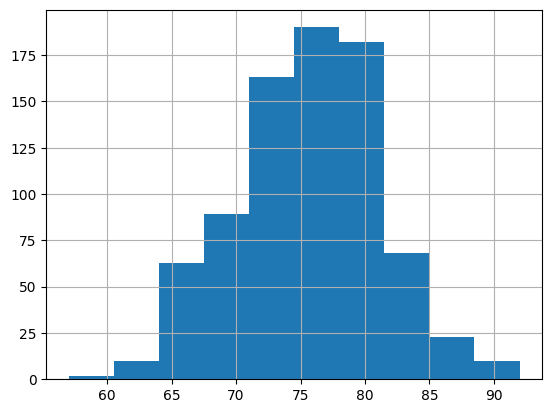

In [11]:
df['target'].hist()

In [12]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [13]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [14]:
y_train.describe()

count    323.000000
mean      76.674923
std        5.286473
min       57.000000
25%       74.000000
50%       77.000000
75%       80.000000
max       91.000000
Name: target, dtype: float64

In [15]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [16]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'criterion': 'entropy',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestClassifier(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAMS_RF = {}

In [17]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'criterion': 'gini',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Create the Decision Tree classifier with the given hyperparameters
        clf = DecisionTreeClassifier(**params)

        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring='recall_macro')
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_DT = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_DT)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_DT = {}

In [18]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_uniform('min_child_weight', 1.0, 20.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0.1, 1.0),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0.01, 0.1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        }
        # Implement early stopping with cross-validation
        cv_scores = []

        clf = XGBClassifier(**params, random_state=42, n_jobs=-1)
        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc
    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_XGB = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_XGB)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_XGB = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


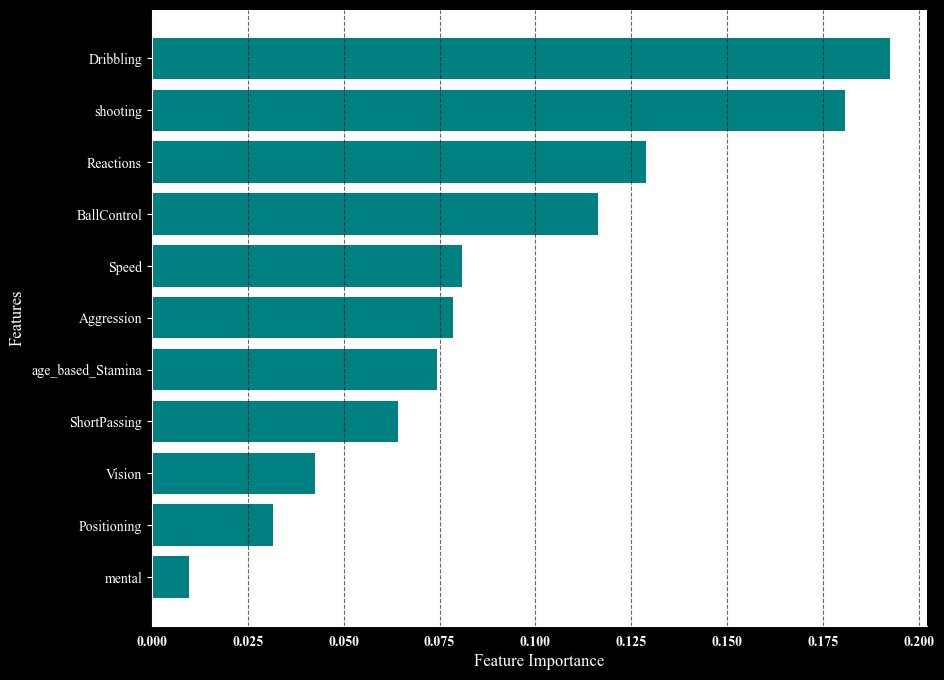

Using 242 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:54<00:00,  1.82s/it]


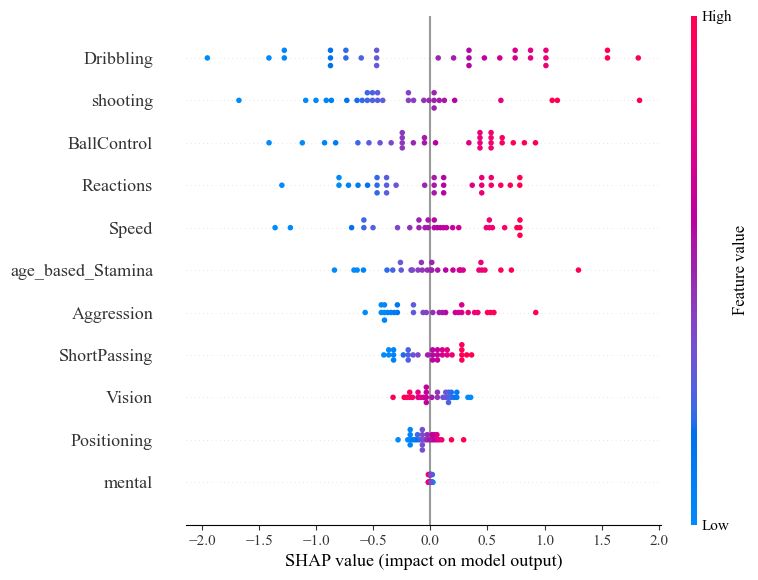

              precision    recall  f1-score   support

       False       0.92      0.97      0.94       219
        True       0.40      0.17      0.24        23

    accuracy                           0.90       242
   macro avg       0.66      0.57      0.59       242
weighted avg       0.87      0.90      0.88       242

Linear Regression training----->


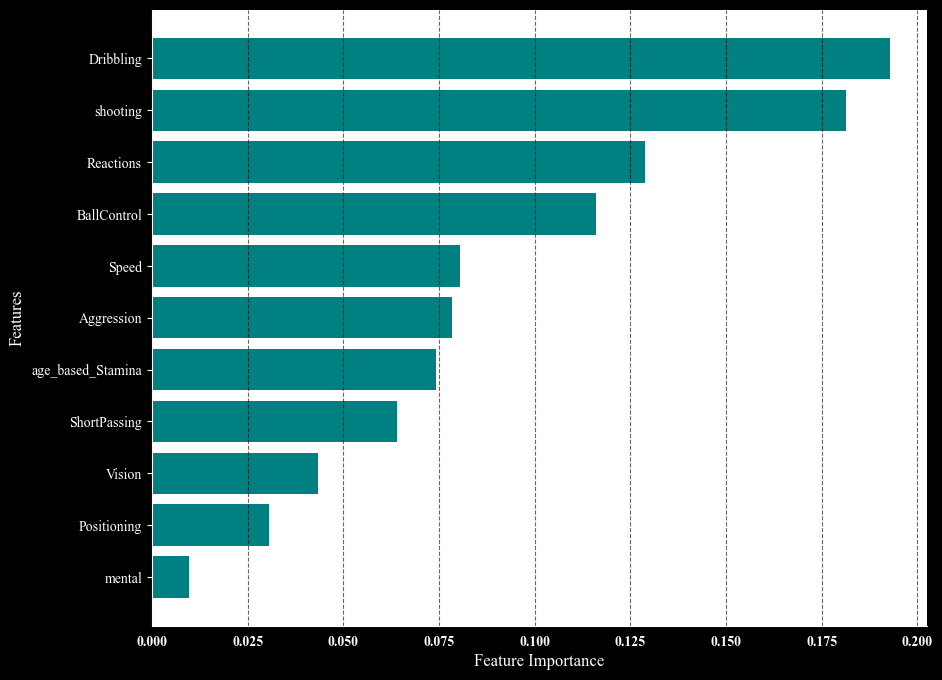

Using 242 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


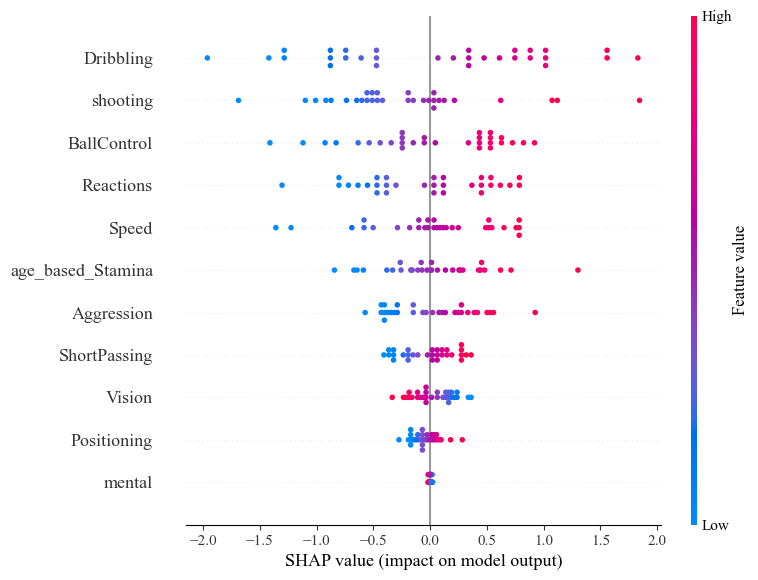

              precision    recall  f1-score   support

       False       0.92      0.97      0.94       219
        True       0.40      0.17      0.24        23

    accuracy                           0.90       242
   macro avg       0.66      0.57      0.59       242
weighted avg       0.87      0.90      0.88       242

Random Forest Regressor training----->


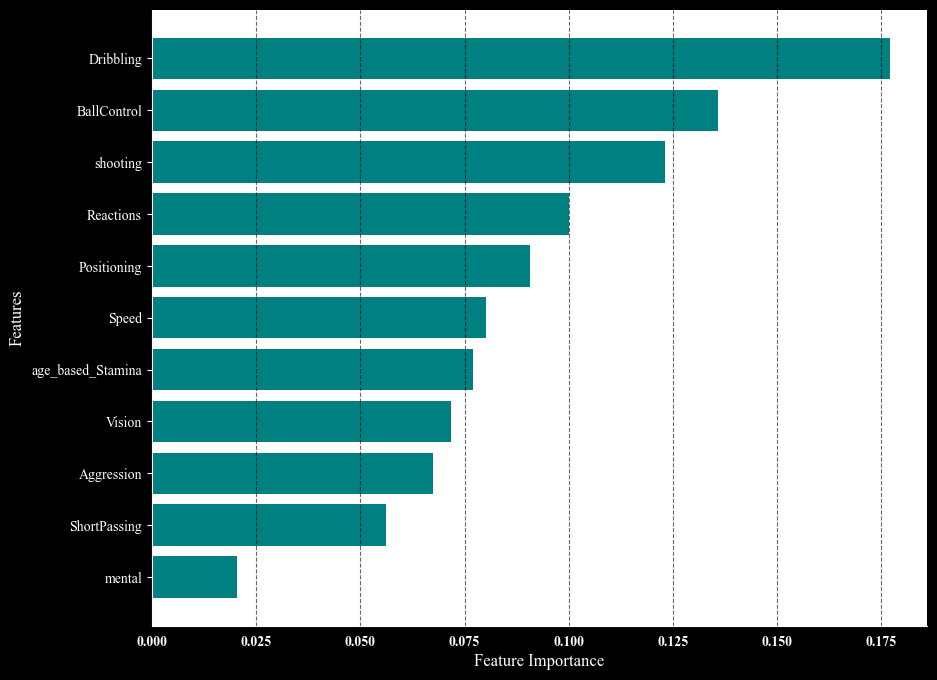

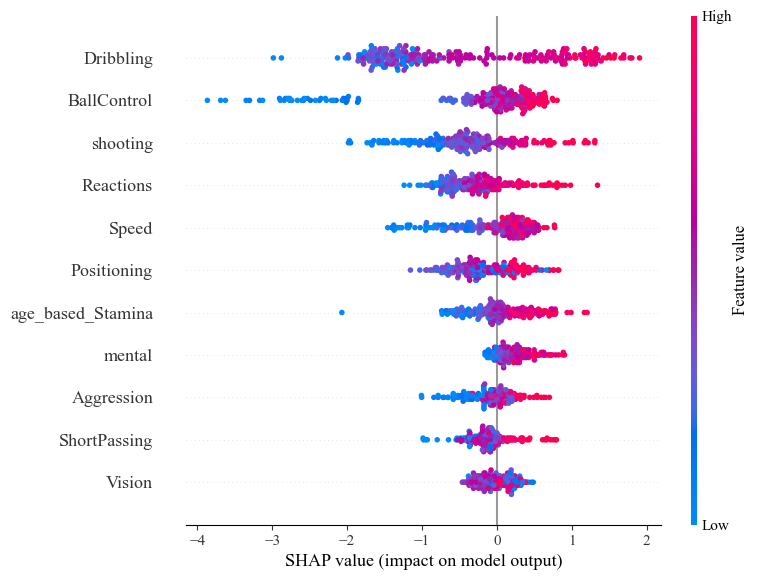

              precision    recall  f1-score   support

       False       0.92      0.96      0.94       219
        True       0.33      0.17      0.23        23

    accuracy                           0.89       242
   macro avg       0.63      0.57      0.58       242
weighted avg       0.86      0.89      0.87       242

Gradient Boosting Regressor training----->


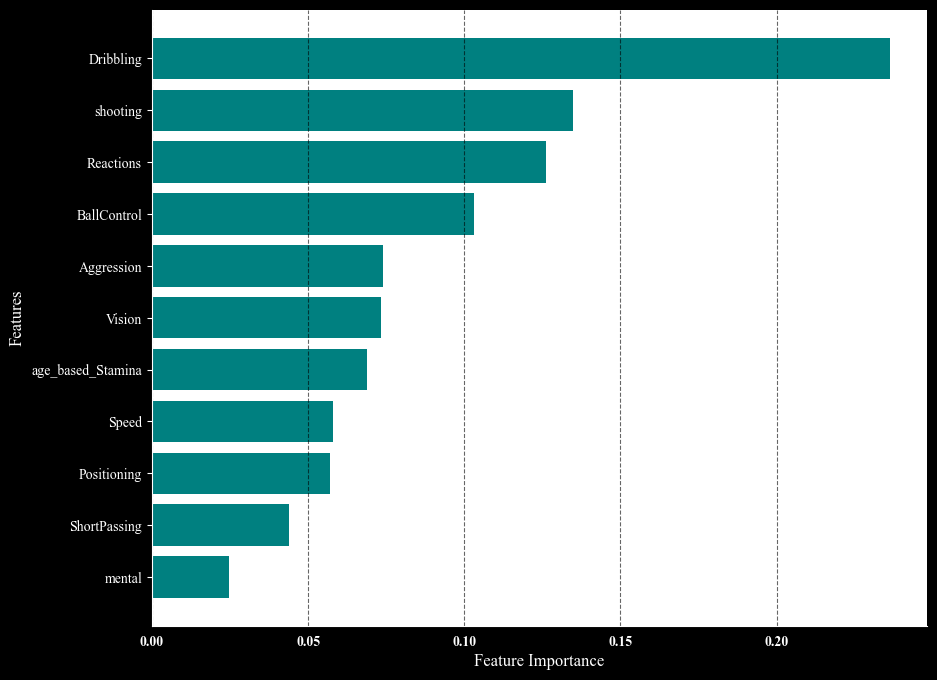

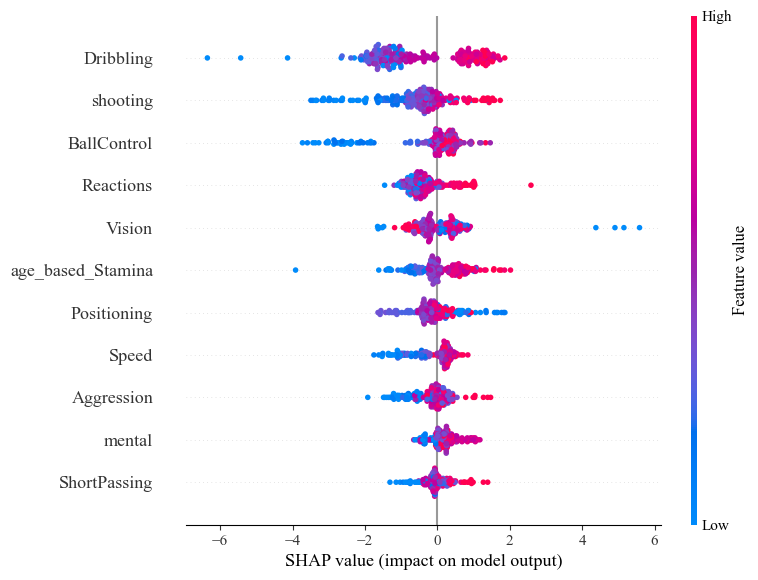

              precision    recall  f1-score   support

       False       0.91      0.95      0.93       219
        True       0.20      0.13      0.16        23

    accuracy                           0.87       242
   macro avg       0.56      0.54      0.54       242
weighted avg       0.84      0.87      0.86       242

Model: Ridge Regression
Mean Squared Error: 19.59
Mean Absolute Error: 3.61
R2 Score: 0.33

Model: Linear Regression
Mean Squared Error: 19.59
Mean Absolute Error: 3.61
R2 Score: 0.33

Model: Random Forest Regressor
Mean Squared Error: 20.81
Mean Absolute Error: 3.73
R2 Score: 0.28

Model: Gradient Boosting Regressor
Mean Squared Error: 23.73
Mean Absolute Error: 3.91
R2 Score: 0.18



In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

from src.sport_analytics.model.eval import plot_feature_importance, log_metrics_in_mlflow_regression,log_metrics_in_mlflow, log_feature_list_as_artifact, plot_shap_summary
from src.sport_analytics.utils import *
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor

regression_models = {
    'Ridge Regression': Ridge(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}
import datetime
# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():
    from datetime import datetime

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        model.fit(X_train_scaled_df, y_train)
       
        y_pred = model.predict(X_test_scaled_df)
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(PLAYER_ATTRIBUTES),
            # 'y_train_positives': y_train.sum(),
            # 'y_train_negatives': (~y_train).sum(),
            # 'y_test_positives': y_test.sum(),
            # 'y_test_negatives': (~y_test).sum(),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df)
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        plot_shap_summary(model=model,df=X_test_scaled_df,K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        from sklearn.metrics import  classification_report
        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'attributes': PLAYER_ATTRIBUTES,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [20]:
from src.sport_analytics.model.utils import *
if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.TRAINED_MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [21]:
y_test.describe()

count    242.000000
mean      73.731405
std        5.403066
min       58.000000
25%       70.000000
50%       74.000000
75%       77.000000
max       91.000000
Name: target, dtype: float64

In [22]:
my_model = regression_results['Linear Regression']['Model']


In [23]:
result_df = pd.Series(my_model.predict(X_test_scaled_df),index=X_test_scaled_df.index)
len(result_df)

242

<Axes: >

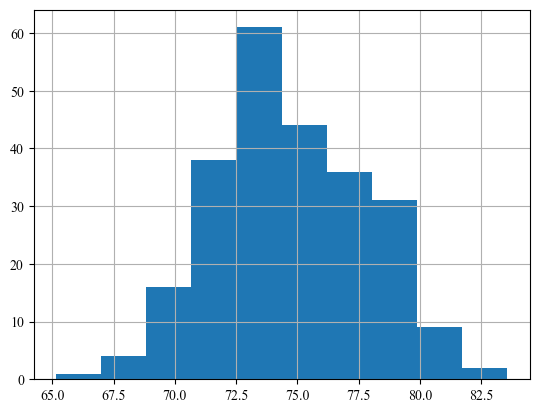

In [24]:
result_df.sort_values(ascending=False).hist()

In [25]:
bool_ = (result_df>=TARGET_OVERALL-3)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

16


ID      Name              FIFA
243812  Rodrygo           2021    83.560129
255475  Antony            2021    82.889017
235944  Brais Méndez      2019    78.045278
241721  Rafael Leão       2020    79.955871
239085  E. Håland         2020    79.414697
231447  D. Malen          2020    80.721311
210315  De Tomás          2020    80.096943
246186  Arthur Cabral     2021    77.015652
236786  M. Terrier        2019    77.888403
221479  D. Calvert-Lewin  2020    80.379444
240690  N. González       2019    77.128788
209519  G. Laborde        2018    77.922439
246242  B. Dia            2021    77.644562
228520  E. Ávila          2020    78.497930
221697  O. Watkins        2019    77.213080
207421  L. Trossard       2020    81.118193
dtype: float64

In [26]:
bool_ = (result_df<TARGET_OVERALL-3)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

17


ID      Name                FIFA
241852  M. Diaby            2019    73.403650
233500  L. Sinisterra       2020    75.685830
231478  L. Martínez         2018    75.719685
251852  K. Adeyemi          2021    76.808168
246191  J. Álvarez          2020    75.573864
240243  Matheus Cunha       2019    74.572629
233731  A. Isak             2018    74.539221
253072  D. Núñez            2021    76.760949
232293  V. Osimhen          2019    73.334302
246430  D. Vlahović         2021    74.834644
224179  Borja Iglesias      2019    75.799222
243580  I. Openda           2019    69.593576
239207  M. Gómez            2018    74.988721
242444  João Félix          2019    76.613305
251566  Gabriel Martinelli  2020    75.051112
225085  J. Bamba            2018    76.569676
243630  J. David            2020    76.988057
dtype: float64

In [27]:
bool_ = (result_df>TARGET_OVERALL-3)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

52


ID      Name                FIFA
247181  G. Plata            2021    79.420463
236920  J. Kluivert         2018    78.604705
243014  B. Mbeumo           2021    78.736576
220710  H. Wilson           2020    78.628557
232080  J. Harrison         2018    77.061645
240017  A. Olsen            2020    78.739266
222825  C. Akolo            2018    77.210184
219536  I. Pussetto         2019    79.252734
237960  Mama Baldé          2020    79.031184
231726  A. Ivan             2019    77.278352
236245  A. Elis             2018    78.719131
229556  Allano              2019    78.144393
233631  A. Ndiaye Diedhiou  2018    79.455260
245158  L. Suárez           2021    79.845810
244622  Puado               2020    77.258645
231447  D. Malen            2020    80.721311
246186  Arthur Cabral       2021    77.015652
231745  L. Dimata           2018    77.263451
221014  Carlos Fernández    2020    77.528887
241026  T. Chancalay        2019    77.224555
235866  C. Kouamé           2020    78.803968
2

In [28]:
bool_ = (result_df<=TARGET_OVERALL-3)&(y_test>TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

12


ID      Name                FIFA
241852  M. Diaby            2019    73.403650
231478  L. Martínez         2018    75.719685
240243  Matheus Cunha       2019    74.572629
233731  A. Isak             2018    74.539221
253072  D. Núñez            2021    76.760949
232293  V. Osimhen          2019    73.334302
246430  D. Vlahović         2021    74.834644
224179  Borja Iglesias      2019    75.799222
243580  I. Openda           2019    69.593576
242444  João Félix          2019    76.613305
251566  Gabriel Martinelli  2020    75.051112
243630  J. David            2020    76.988057
dtype: float64

In [29]:
bool_ = (result_df<TARGET_OVERALL-3)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

162


ID      Name            FIFA
233795  B. Brereton     2019    75.481439
254247  M. Mohamed      2021    75.513820
248060  V. Mihăilă      2021    75.564675
240740  C. Hudson-Odoi  2019    75.599764
231113  Z. Bakaev       2020    75.606265
251954  C. Summerville  2021    75.641220
252042  João Pedro      2021    75.840520
246147  M. Greenwood    2020    75.944849
246145  I. Aliseda      2020    75.956925
246045  P. De la Vega   2020    76.186417
213418  C. Akpom        2020    76.209824
242162  H. Evjen        2020    76.243047
245396  V. Supryaga     2021    76.480344
241508  M. Damsgaard    2020    76.510030
220287  J. Dinenno      2021    76.562276
237512  G. Togni        2021    76.656221
251105  D. Joveljić     2020    76.702992
251756  R. Nteka        2021    76.843668
233848  J. Hauge        2021    76.911049
240037  S. Plavšić      2018    76.938493
dtype: float64

In [30]:
from sklearn.metrics import  classification_report
print(classification_report(y_test>78, result_df>75))

              precision    recall  f1-score   support

       False       0.91      0.63      0.74       201
        True       0.28      0.71      0.40        41

    accuracy                           0.64       242
   macro avg       0.60      0.67      0.57       242
weighted avg       0.81      0.64      0.69       242

